## Task
    1. Turn it int script 
    2. Fix pdf download script(done)
    3. Google blocked again
    4. download in headless
    5. remove the broken file entry and file, after download is complete(done)
    6. reload after stuck(done)
    7. Download sound alert(done)

## importing libraries

In [1]:
# from googlesearch import search
import webbrowser
import re
import urllib.request
import requests
import bs4
from fake_useragent import UserAgent

In [2]:
import pandas as pd
import numpy as np
from fake_useragent import UserAgent
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

In [161]:
import shutil

In [115]:
import winsound

In [3]:
import re
import os

In [4]:
# from googlesearch import search

In [5]:
import time

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys#allows to use Enter, Esc keys
from selenium.webdriver import ActionChains

## Colors

In [8]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


## Customizing graph

In [9]:
##customizing matplotlib
plt.rcParams['figure.figsize'] = [10,8]# for 8:5 ratio
plt.rcParams['font.size'] = 14
plt.style.use('seaborn-whitegrid')

## Reading the list

In [10]:
def get_comp_list(path = "Top 500 companies.txt"):
    with open(path, "r") as f:
        comp_list = f.readlines()
    return comp_list

## Searching PDF with no block(new)

In [11]:
def google_results(keyword, n_results=10):
    #sleep before making requests
    time.sleep(.600)
    query = keyword
    query = urllib.parse.quote_plus(query) # Format into URL encoding
    number_result = n_results
       
    ua = UserAgent()
    google_url = f"https://www.google.com/search?q= {query} &num= + {number_result}"
    
    
    response = requests.get(google_url, {"User-Agent": ua.random})
#     response = requests.get(google_url, {"User-Agent":'Mozilla/5.0'})
    
    soup = BeautifulSoup(response.content)
    
    links = get_links(soup)
    titles = get_title_list(soup)
    desc_list = get_desc(soup)
    lst = []
    for (l,t,d) in zip(links,titles,desc_list):
        lst.append({"title" : t, "link" : l, "desc" : d})
    return lst[:number_result]

def get_links(soup):
    result = soup.find_all('div', attrs = {'class': 'ZINbbc'})
    pattern = '\/url\?q\=(.*)\&sa'
    results = []
    for i in result:
        if "url" in str(i):
            text = str(i.find('a', href = True)['href'])
            results.append(re.search(pattern,text))
    #group(1) returns the text of the match object
    links=[i.group(1) for i in results if i != None]
    return links

def get_title_list(soup):
    result = soup.find_all('h3', attrs = {'class': 'zBAuLc'})
    titles = [i.text for i in result]
    return titles

def get_desc(soup):
    result = soup.findAll(True, {'class':"kCrYT"})
    desc_list = []
    for i,r in enumerate(result):
        if i % 2 != 0:
            desc_list.append(r.text)     
    return desc_list



In [12]:
def search_and_get_pdf(n = None,year = None, c=None):
    if c == None:
        c = int(input("Enter\n1. Normal Downlaod\n2. Redownload \n"))
    if c == 1:
        comp_list = get_comp_list()
        if year == None:
            year = int(input("Enter year : "))
        if n == None:
            n = int(input("\nHow many companies would you like to search? : "))
            comp_subset = comp_list[:n]
    elif c == 2:
        comp_subset = get_redownload_list(year)
    else:
        return None
    
    print(f"\nInitiating search of Annual reports for the {year}......\n")
    time.sleep(2)
    dic = {}
    for x in comp_subset:
        comp = x.strip()
        #if the pdf of a year exist
        if os.path.exists(f"pdf/{year}") == False:
            os.mkdir(f"pdf/{year}")
        if c == 1:
            if os.path.exists(f"pdf/{year}/{comp}"):
                if os.listdir(f"pdf/{year}/{comp}") != []:
                    print(f"{comp} already downloaded! Skipping search!")
                    continue
        
#       query = f"{comp} annual report site:\"https://www.bseindia.com\" filetype:pdf intext:\"{year} {year+1}\" " 
#         query = f"{comp} bse annual report {year}-{year+1} filetype:pdf intext:\"{comp}\" "
        query = f"{comp} bse annual report {year} filetype:pdf intext:\"{comp}\" "

#             query2 = f"{comp} annual report 2019-20 intext:\"Do you have a policy\" filetype:pdf"
        print(f"\nLinks for {comp} --------------------------------------------\n")
        links = []
        link = ""
        title = ""
        desc = ""
        result = google_results(query,1)
        for r in result:
            title = r["title"]
            desc = r["desc"]
            link = r["link"]
            print(f"\nTitle : {color.BOLD}{title}{color.END}")
            print(f"Description : {desc}")
            print(f"link :{link}")
#             if f"{year-1}" in desc or f"{year-1}" in title:
#                 print("SKIPPING.......")
#                 continue
            links.append(link)
#             break
        dic[x] = links
    return dic

## Downloading PDF from the list of links

In [13]:
def get_filesize(download_path):
    file_size = os.path.getsize(f"{download_path}")
    return file_size

In [14]:
def validate_links(file_name):
    pass

In [15]:
def get_filename(y):
    #check for pdf extension in link if not then add
    if re.findall("pdf", y) == []:
        file_name = os.path.split(y)[1] + ".pdf"
    else:
        file_name = os.path.split(y)[1]
    ##check for pdf in filename
    if re.findall("pdf",file_name) == []:
        y = y.replace(file_name,"")
        file_name = os.path.split(y[:-1])[1]
    
    i = file_name.find("pdf")
    if i > 0:
        file_name =  file_name[:i+3]
        
    ##check for special characters
    pattern= "'[@!#$^&*%<>?/\\|}{~:]'\"="
    
    for x in pattern:
        n = file_name.replace(x,"")
        file_name = n
    return n

In [16]:
##download directly
def download_pdf_direct(link,file_name,year,company_name):
    path = f"pdf/{year}/{company_name}/{file_name}"
    ua = UserAgent()
    try:
        response = requests.get(link, {"User-Agent": ua.random}, timeout = 180)
        save_file(response,file_name,path)
        return True
    except:
        return False

In [17]:
def save_file(response,filename,download_path):
#     download_path = "temp/test_file2.pdf"
    with open(f"{download_path}", 'wb') as pdf:
        pdf.write(response.content)
    file_size = os.path.getsize(f"{download_path}")
    size = round(file_size/(1024),3)
    print(f"\tdownloaded filesize : {size}KB")

## SELENIUM

In [18]:
def download_wait(path_to_downloads):
    seconds = 0
    dl_wait = True
    while dl_wait:
        time.sleep(1)
        for fname in os.listdir(path_to_downloads):
            if fname.endswith('.crdownload'):
                dl_wait = True
            else:
                dl_wait = False
                

In [19]:
def download_pdf_selenium(year,company_name):
    PATH = "Driver/Win 7/chromedriver.exe"
#     d_path = f"C:\\Users\\Rahul\\Desktop\\ESG\\pdf grabber\\pdf\\{year}\\{company_name}"
    d_path = f"D:\\Python_projects\\ESG\\pdf grabber\\pdf\\{year}\\{company_name}"
#     d_path =  r"C:\Users\Rahul\Desktop\ESG\pdf grabber\pdf"
    print(company_name)
    query = f"{company_name} bse annual report {year} filetype:pdf intext:\"{company_name}\" "
    options = webdriver.ChromeOptions()

    options.add_experimental_option('prefs', {
    "download.default_directory": d_path ,
    "download.prompt_for_download": False, #To auto download the file
    "download.directory_upgrade": True,
    "plugins.always_open_pdf_externally": True #It will not show PDF directly in chrome
    })
    
    
    driver = webdriver.Chrome(options=options,executable_path = PATH)
        
    
    driver.get("https://www.google.com")
    driver.find_element_by_name("q").send_keys(query,Keys.ENTER)
    first_link = driver.find_element_by_xpath("//h3[@class = 'LC20lb DKV0Md']")
    first_link.click()
    time.sleep(6)
    
    #wait untill the download is complete then close the browser
    print(f"\t{company_name} download started")
    download_wait(d_path)
    driver.quit()
    


In [20]:
##download at each folder
def download_all_pdf(dic,year = None):
    if year == None:
        year = int(input("Enter year : "))
    error_files = []
    stuck_files = []
    for x in dic:
        company_name = x.strip()
        link_of_pdfs = dic[x]
        path = "pdf"
        download_path = f"{path}/{year}/{company_name}"
        #go to pdf and create folder
        if os.path.exists(f"{path}/{year}") == False:
            os.mkdir(f"{path}/{year}")
        if os.path.exists(download_path) == False:
            os.mkdir(download_path)
        f_size = get_filesize(f"{download_path}")
        if os.listdir(download_path) == [] or f_size < 10000:
            print(f"\nDownloading report for {company_name}")
            check = ""
            for y in link_of_pdfs:
                #gets the pdf name from the link
                file_name = get_filename(y)
                try:
#                     print(f"{y}\n{file_name}\n{company_name}")
                    check = download_pdf_direct(y,file_name,year,company_name)
                    
                except:
                    print(f"!!!!!------------Some error occured while downloading {file_name}, skipping to next link.")
                    error_files.append(company_name)
            if check:
                print(f"\t{company_name} report downloaded")
            else:
                print("!!!!------File is taking too long to download, trying different method")
                ##reload using selenium
                download_pdf_selenium(year,company_name)
                print("Download successful using selenium")
#                 stuck_files.append(company_name)
    
    print("----------------------------------------------------------------------------------")
    print("All download complete!")
    
    
    if error_files != []:
        print("List of company not downloaded")
        with open(f"pdf/logs/failed_files_{year}.txt","w") as f:
            for x in error_files:
                print(f"\t{x}")
                f.write(f"{x}\n")
                
    if stuck_files!= []:
        print("List of company skipped as it took too long to download ")
        with open(f"pdf/logs/stuck_files_{year}.txt","w") as f:
            for x in stuck_files:
                print(f"\t{x}")
                f.write(f"{x}\n")

## Validate downloaded files

## Check files

In [54]:
def check_files(year):
    f = open(f"pdf/logs/broken_files_{year}.txt","w")
    f2 = open(f"pdf/logs/success_files_{year}.txt","w")
    c = 0
    for i in os.listdir(f"pdf/{year}/"):
        path = f"pdf/{year}/{i}/"

        file = os.listdir(path)
        if file == []:
            continue
        file_path = path+file[0]
        file_size = os.path.getsize(file_path)
#         print(f"{i} File Size is :{file_size} bytes")
        #add to broken download list
        if file_size < 90000:
            f.write(f"{i}\n")
            print(f"{i} file size is too small {file_size} bytes\n")
            c =c + 1
        #add to success download list
        else:
            f2.write(f"{i}\n")
    f.close()
    f2.close()
    
    if c == 0:
        return False
    else:
        print(f"{c} broken files found\n")
        return True

## Get redownload list

In [22]:
def get_redownload_list(year):
    path = f"pdf/logs/broken_files_{year}.txt"
    with open(path, "r") as f:
        r_list = f.readlines()
    return r_list

## get summary of download

In [23]:
def get_count(filepath):
    c = 0
    with open(filepath, "r") as file:
        Content = file.read()
        CoList = Content.split("\n")

        for i in CoList:
            if i:
                c += 1

    return c

In [165]:
def describe(year):
    succ_path = f"pdf/logs/success_files_{year}.txt"
    broken_path = f"pdf/logs/broken_files_{year}.txt"
    failed_path = f"pdf/logs/failed_files_{year}.txt"
    stuck_path = f"pdf/logs/stuck_files_{year}.txt"
    
    sum_success = 0
    sum_stuck = 0
    sum_broken = 0
    sum_fail = 0
    
    if os.path.exists(succ_path):
        sum_success = get_count(succ_path)
    if os.path.exists(failed_path):
        sum_fail = get_count(failed_path)
    if os.path.exists(broken_path):
        sum_broken = get_count(broken_path)
    if os.path.exists(stuck_path):
        sum_stuck = get_count(stuck_path)
    
    sum_missing = 0
    for d in os.listdir("pdf/2017/"):
        if os.listdir(f"pdf/2017/{d}") == []:
            sum_missing= + 1
    
    total = sum_broken + sum_fail + sum_stuck + sum_success + sum_missing
    print(f"""
    Downlaod summary {year}:
    1. Success : {sum_success} ({round(sum_success/total*100,2)}%)
    2. Stuck : {sum_stuck} ({round(sum_stuck/total*100,2)}%)
    3. Broken : {sum_broken} ({round(sum_broken/total*100,2)}%)
    4. Failed : {sum_fail} ({round(sum_fail/total*100,2)}%)
    5. Missing : {sum_missing} ({round(sum_missing/total*100,2)}%)
    Total : {total}
    """)
    

In [110]:
def describe_all():
    year = [2017,2018,2019]
    sum_success = []
    sum_stuck = []
    sum_broken = []
    sum_fail = []
    
    for i in year:
        succ_path = f"pdf/logs/success_files_{i}.txt"
        broken_path = f"pdf/logs/broken_files_{i}.txt"
        failed_path = f"pdf/logs/failed_files_{i}.txt"
        stuck_path = f"pdf/logs/stuck_files_{i}.txt"

        if os.path.exists(succ_path):
            sum_success.append(get_count(succ_path)) 
        else:
            sum_success.append(0) 
            
        if os.path.exists(failed_path):
            sum_fail.append(get_count(failed_path))
        else:
            sum_fail.append(0) 
        if os.path.exists(broken_path):
            sum_broken.append(get_count(broken_path)) 
        else:
            sum_broken.append(0) 
        if os.path.exists(stuck_path):
            sum_stuck.append(get_count(stuck_path)) 
        else:
            sum_stuck.append(0) 
            
    d = {'Year':year,
         'Success' : sum_success,
         'Failed' : sum_fail,
         'Stuck' : sum_stuck,
        'Broken' : sum_broken
        }

    df = pd.DataFrame(d)
    plt.subplot(2,2,1)
    sns.barplot(data=df,x= 'Year', y = 'Success');
    plt.subplot(2,2,2)
    sns.barplot(data=df,x= 'Year', y = 'Failed');
    plt.subplot(2,2,3)
    sns.barplot(data=df,x= 'Year', y = 'Broken');
    plt.subplot(2,2,4)
    sns.barplot(data=df,x= 'Year', y = 'Stuck');
    plt.show()
    print("\n\n---------------------Stacked plot---------------------\n\n")
    print(df)
    x = df["Year"]
    plt.bar(x,df["Success"],0.5,label="Success")
    plt.bar(x,df["Broken"],0.5,bottom = df["Success"],label="Broken")
    plt.bar(x,df["Stuck"],0.5,bottom = df["Broken"],label="Stuck")
    plt.bar(x,df["Failed"],0.5,bottom = df["Stuck"],label="Failed")
    plt.xticks(df["Year"])
    plt.xlabel("Year")
    plt.ylabel("Download Summary")
    plt.legend()
    plt.show()

## Redownload stuck files()

In [26]:
def get_stuck_list(year):
    stuck_path = f"pdf/logs/stuck_files_{year}.txt"
    l = []
    if os.path.exists(stuck_path):
        with open(stuck_path, "r") as f:
            l = f.readlines()
            
    return l
    

In [27]:
def redownload_stuck(year):
    l = get_stuck_list(year)
    for comp_name in l:
        comp_name = comp_name.replace("\n","")
        if os.listdir(f"pdf/{year}/{comp_name}/") == []:
            download_pdf_selenium(year,comp_name)
            print(f"{comp_name} download complete")
        else:
            print(f"{comp_name} already downloaded!!")

#         time.sleep(300)
        ## close the browser after the download is complete
        

## delete broken files and redownload

In [28]:
def get_broken_list(year):
    stuck_path = f"pdf/logs/broken_files_{year}.txt"
    l = []
    if os.path.exists(stuck_path):
        with open(stuck_path, "r") as f:
            l = f.readlines()
            
    return l

In [162]:
def redownload_broken(year):
    l = get_broken_list(year)
    for comp_name in l:
        comp_name = comp_name.replace("\n","")
        ##delete all the file inside the folder
        dir_path = f"pdf/{year}/{comp_name}/"
        for i in os.listdir(dir_path):
            try:
                os.remove(os.path.join(dir_path, i))
            except Exception as e:
                beep(1000,1000)
                print(f"Unwated folder found, tring to remove folder")
                print(f"\t{e}")
                try:
                    shutil.rmtree(os.path.join(dir_path, i))
                    print("Succesfully removed")
                except Exception as e:
                    print(f"\t{e}")
                    
        #then checks if folder is empty then downlaod    
        if os.listdir(dir_path) == []:
            download_pdf_selenium(year,comp_name)
            beep(528,600)
            print(f"\t{comp_name} download complete")


In [30]:
# redownload_stuck(2018)

## Beep sound

In [149]:
def beep(f=2000,d=3000):
    pass
#     winsound.Beep(f,d)

## Start search and download

In [157]:
def start_it():
    y = int(input("Enter year :"))
#     year = y
    choice = ""
    if os.path.exists(f"pdf/{y}"):
        print("\nChecking previous downloads for broken files......\n")
        time.sleep(2)
        if check_files(y):
            choice = input("Do you want to re-download these files? y or n :")
        else:
            print("No broken files found")
    if choice == "y":
        redownload_broken(y)
    else:
        comp_dict = search_and_get_pdf(None,y,1)
        download_all_pdf(comp_dict,y)

    print("\nReckecking for broken downloads.....\n")
    time.sleep(2)
    check_files(y)
    print(color.GREEN + "Everyting is completed successfully!" + color.END)
    beep()
    describe(y)

In [175]:
start_it()

Enter year : 2019



Checking previous downloads for broken files......

ACC file size is too small 345 bytes

Aditya Birla Capital file size is too small 345 bytes

Ambuja Cements file size is too small 345 bytes

Apollo Tyres file size is too small 345 bytes

Ashok Leyland file size is too small 345 bytes

Asian Paints file size is too small 731 bytes

Aurobindo Pharma file size is too small 345 bytes

Avenue Supermarts file size is too small 345 bytes

Bank of India file size is too small 345 bytes

Bharat Heavy Electricals file size is too small 345 bytes

Bharti Airtel file size is too small 345 bytes

Cadila Healthcare file size is too small 3817 bytes

Canara Bank file size is too small 345 bytes

Citibank file size is too small 345 bytes

EID Parry (India) file size is too small 345 bytes

General Insurance Corporation of India file size is too small 345 bytes

HDFC file size is too small 345 bytes

HDFC Bank file size is too small 345 bytes

Hero MotoCorp file size is too small 42054 bytes

Hindu

Do you want to re-download these files? y or n : n

How many companies would you like to search? :  30



Initiating search of Annual reports for the 2019......

Reliance Industries already downloaded! Skipping search!
Indian Oil Corporation already downloaded! Skipping search!
Oil & Natural Gas Corporation already downloaded! Skipping search!
State Bank of India already downloaded! Skipping search!
Bharat Petroleum Corporation already downloaded! Skipping search!
Tata Motors already downloaded! Skipping search!
Rajesh Exports already downloaded! Skipping search!
Tata Consultancy Services already downloaded! Skipping search!
ICICI Bank already downloaded! Skipping search!
Larsen & Toubro already downloaded! Skipping search!
HDFC Bank already downloaded! Skipping search!
Tata Steel already downloaded! Skipping search!
Hindalco Industries already downloaded! Skipping search!
NTPC already downloaded! Skipping search!
HDFC already downloaded! Skipping search!
Coal India already downloaded! Skipping search!
Mahindra & Mahindra already downloaded! Skipping search!
Infosys already downloaded! Sk

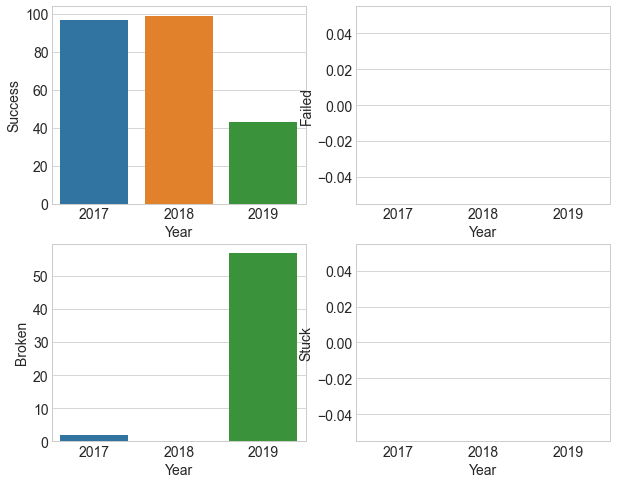



---------------------Stacked plot---------------------


   Year  Success  Failed  Stuck  Broken
0  2017       97       0      0       2
1  2018       99       0      0       0
2  2019       43       0      0      57


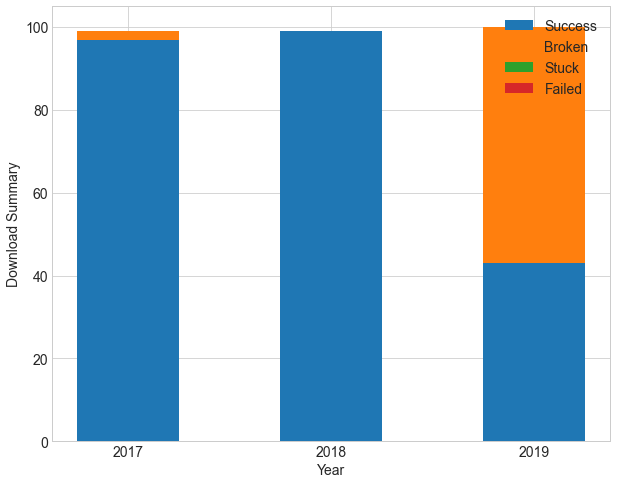

In [176]:
describe_all()